In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [ ]:
import zipfile
import os

# Specify the path to your uploaded zip file
zip_file_path = '/content/archive (1).zip'

# Specify the destination folder where you want to unzip the contents
destination_folder = '/content'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Print a message indicating successful extraction
print(f'Contents of {zip_file_path} successfully extracted to {destination_folder}')

Contents of /content/archive (1).zip successfully extracted to /content


In [ ]:
train_dir = '/content/train/'
test_dir = '/content/test/'

def Classes_Count(path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)  # Use os.path.join for path concatenation
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

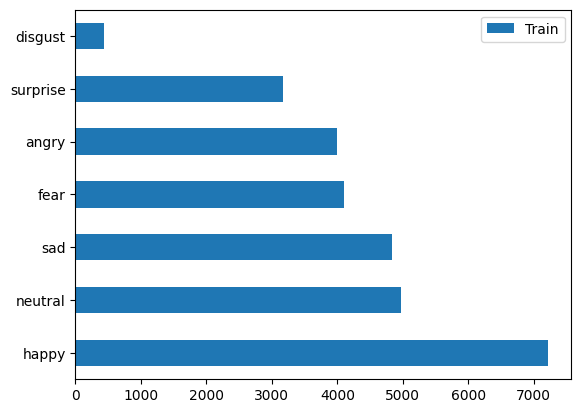

In [ ]:
Train_Count.plot(kind='barh')


<Axes: >

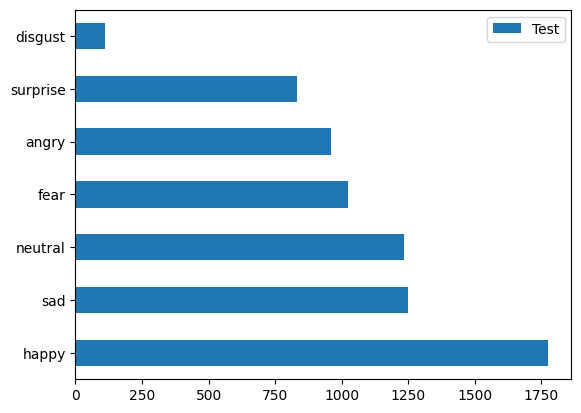

In [ ]:
Test_Count.plot(kind='barh')

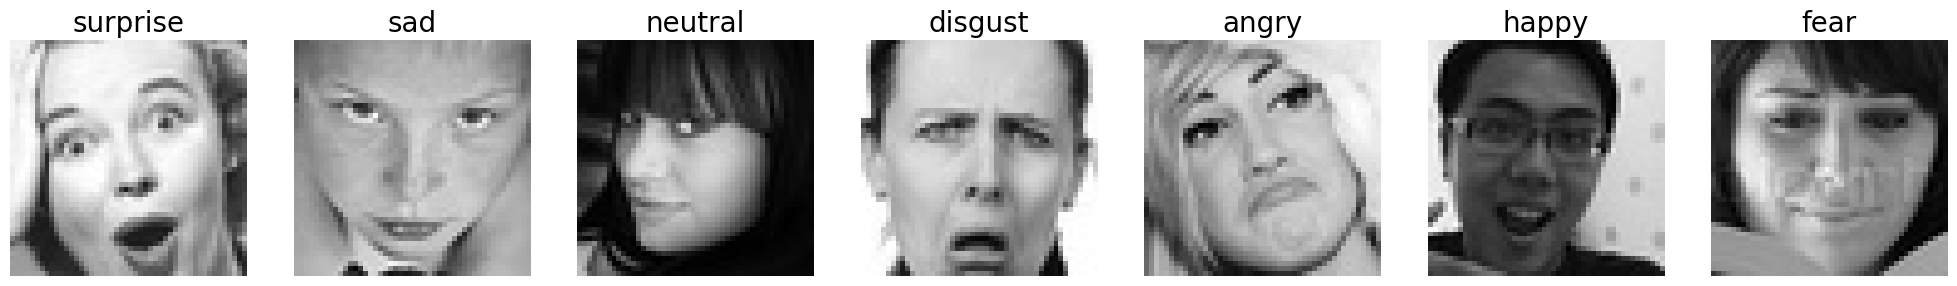

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(25, 8))

image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(os.path.join(BASE_URL, directory))):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image_path = os.path.join(BASE_URL, directory, file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                plt.imshow(image)
                plt.title(directory, fontsize=20)
                plt.axis('off')  # Turn off axis labels and ticks

plt.show()


In [ ]:
img_shape = 224
batch_size = 32
train_data_path = '/content/train'
test_data_path = '/content/test'

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet')

#ResNet50V2.summary()

In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size


In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=2, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/2
897/897 [==============================] - 9696s 11s/step - loss: 1.6175 - accuracy: 0.4345 - val_loss: 1.3083 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 2/2
897/897 [==============================] - 9506s 11s/step - loss: 1.3140 - accuracy: 0.5188 - val_loss: 1.3304 - val_accuracy: 0.5292 - lr: 0.0010


In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

225/225 [==============================] - 1149s 5s/step - loss: 1.3298 - accuracy: 0.5294
    Test Loss: 1.32985
Test Accuracy: 52.94%


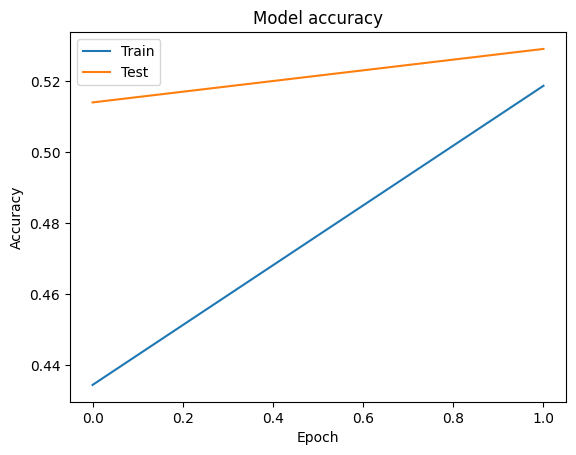

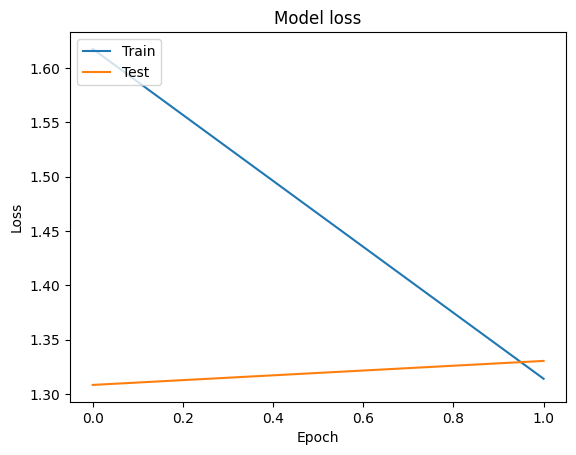

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Assuming you have already trained the model and have the history
# ResNet50V2_history = ResNet50V2_Model.fit(...)

# Then you can call the function to plot curves
plot_curves(ResNet50V2_history)


In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

225/225 [==============================] - 1152s 5s/step


In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


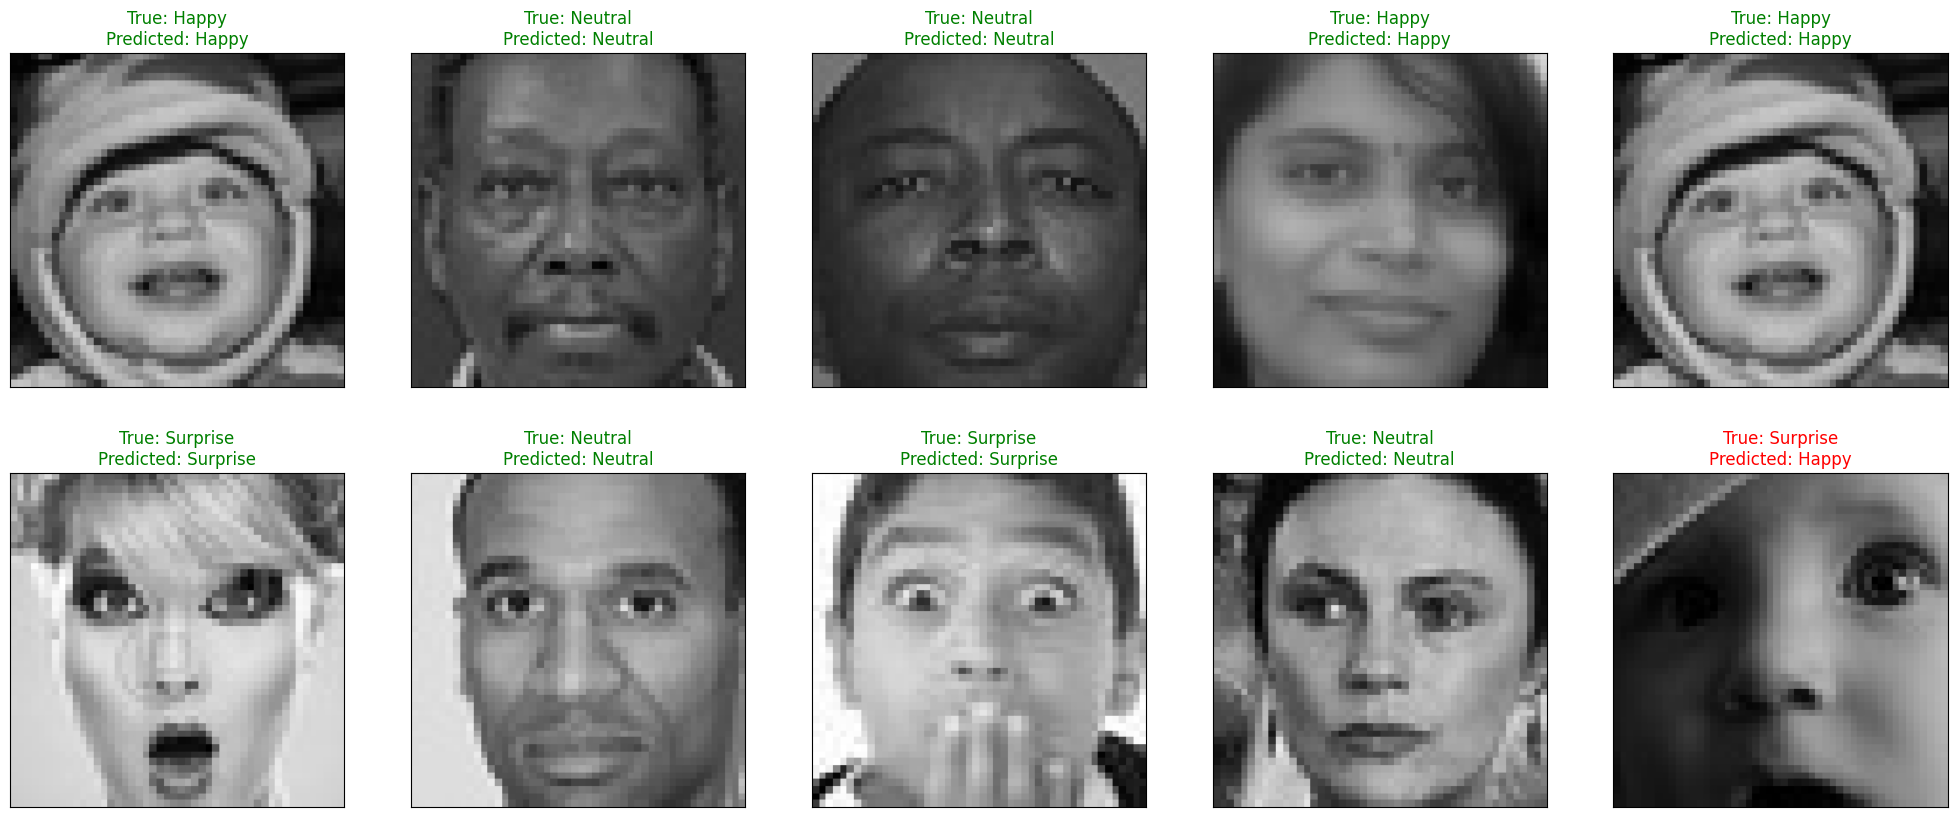

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
Music_Player = pd.read_csv("/content/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [ ]:
Music_Player["mood"].value_counts()


Sad          197
Calm         195
Energetic    154
Happy        140
Name: mood, dtype: int64

In [ ]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [ ]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):

    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2024-03-06 06:08:35--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2024-03-06 06:08:35 (36.4 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)

    for x,y,w,h in faces:

        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]

        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)

        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [ ]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    #plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

    Recommend_Songs(pred_class)

1/1 [==============================] - 0s 291ms/step


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


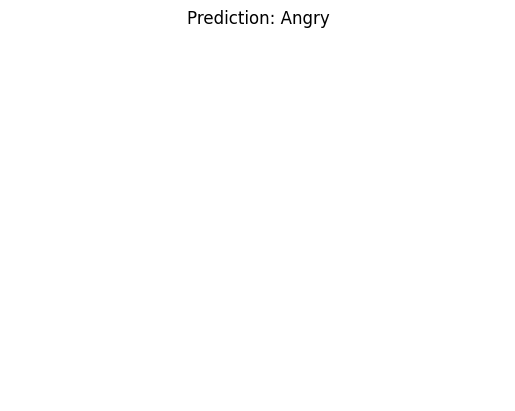

In [ ]:
pred_and_plot("/content/test/angry/PrivateTest_10131363.jpg", Emotion_Classes) # with ResNet50V2

In [ ]:
# Downloading Image to Test On
!wget -c "https://musimorphic.com/wp-content/uploads/2022/10/home-alone-1024x768.jpg" -O fear.jpg

--2024-03-06 06:12:24--  https://musimorphic.com/wp-content/uploads/2022/10/home-alone-1024x768.jpg
Resolving musimorphic.com (musimorphic.com)... 148.72.52.232
Connecting to musimorphic.com (musimorphic.com)|148.72.52.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74582 (73K) [image/jpeg]
Saving to: ‘fear.jpg’

fear.jpg            100%[===================>]  72.83K  --.-KB/s    in 0.1s    

2024-03-06 06:12:25 (502 KB/s) - ‘fear.jpg’ saved [74582/74582]



No Faces Detected
1/1 [==============================] - 0s 197ms/step


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


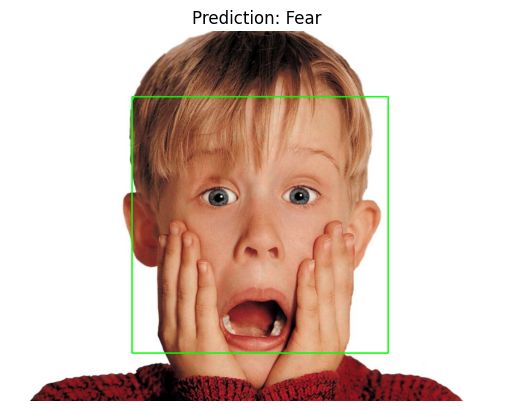

In [ ]:
pred_and_plot("./fear.jpg", Emotion_Classes) # with ResNet50V2

In [ ]:


ResNet50V2_Model.save("ResNet50V2_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os

# Specify the full path to your desktop folder
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "Final Projects")

# Ensure the folder exists, create it if necessary
os.makedirs(desktop_path, exist_ok=True)

# Specify the full path to save the model
save_path = os.path.join(desktop_path, "ResNet50V2_Model.h5")

# Save the model
ResNet50V2_Model.save(save_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the full path on Google Drive where you want to save the model
drive_save_path = '/content/drive/MyDrive/Colab Notebooks/Model/ResNet50V2_Model.h5'

# Save the model
ResNet50V2_Model.save(drive_save_path)
